In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns
import itertools
from sklearn.decomposition import PCA

from sklearn.model_selection             import train_test_split
from recommendation_evaluation_functions import recommend_ingredients, held_out_recommendation, calculate_metrics

%matplotlib inline

In [2]:
# Load data.
X        = pd.read_csv('train_dataset.csv', sep = '\t', index_col = 0).drop('cuisine', axis = 1)
cuisines = pd.read_csv('train_dataset.csv', sep = '\t', usecols = ['cuisine'])
cuisines.set_index(X.index, inplace = True)

## Evaluating a sample of recommendations

In [3]:
# Apply CF to original recipes.
recommendations = recommend_ingredients(X.head(1050), X.head(1050), similarity_measure = "jaccard", k = 5)

In [4]:
# Print some recipe + recommendation samples.
recipe1 = 7
recipe2 = 10

print('Recipe {} ({}): \n{}\n'.format(X.index[recipe1], 
                                      cuisines.iloc[recipe1, 0],
                                      X.columns[np.where(X.iloc[recipe1,] != 0)]))
print('Recommended ingredients: \n{}\n\n'.format(recommendations[5][recipe1,]))

print('Recipe {} ({}): \n{}\n'.format(X.index[recipe2], 
                                      cuisines.iloc[recipe2, 0],
                                      X.columns[np.where(X.iloc[recipe2,] != 0)]))
print('Recommended ingredients: \n{}\n\n'.format(recommendations[5][recipe2,]))

Recipe 16903 (mexican): 
Index(['cheddar_cheese', 'jalapeno_chilies', 'lettuce', 'lime', 'pork',
       'purple_onion', 'peppers', 'olive', 'cilantro_chopped_fresh',
       'pepper_ground_black', 'tortillas_corn'],
      dtype='object')

Recommended ingredients: 
Index(['kosher_salt', 'tortilla', 'garlic_cloves', 'cilantro_chopped',
       'garlic', 'vinegar', 'onions', 'crushed_pepper_flakes', 'beans_black',
       'chile'],
      dtype='object')


Recipe 45887 (chinese): 
Index(['canola', 'garlic', 'mustard', 'scallions', 'sesame', 'sugar', 'wine',
       'starch_corn', 'crushed_pepper_flakes', 'ginger_fresh', 'beans_green',
       'sodium_sauce', 'pepper_white'],
      dtype='object')

Recommended ingredients: 
Index(['vinegar_rice', 'onions_green', 'ginger', 'rice_wine', 'dry_sherry',
       'pork', 'yellow_onion', 'vegetable', 'vinegar',
       'skinless_boneless_chicken'],
      dtype='object')




## Model evaluation

**Split the data into train and test set**

In [5]:
X_train, X_test = train_test_split(X, test_size = 0.9, random_state = 1)

### Tune alpha parameter cosine similarity

In [ ]:
# Initialise dataframe of results
results_alpha_PCA = pd.DataFrame(columns = ["k", "similarity_measure", "top10_presence", "mean_rank", 
                                            "median_rank"])

alpha_grid        = np.linspace(0.05,0.35,7)
user_item_matrix  = X_train

# Fix number of neighbours to 50 and use PCA to evaluate (roughly) the optimal value of alpha
model_config = [50, "asymmetric_cosine", len(X.columns)]

for alpha in alpha_grid:   
    
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config, usePCA = True,
                                                                   alpha = alpha)  
    for k, recs in recommendations.items():
        results_alpha_PCA = results_alpha_PCA.append(calculate_metrics(missing_ingredients, recs, 
                                                                       model_config[0],  
                                                                       model_config[1]),ignore_index = True)

In [ ]:
results_alpha_PCA

In [ ]:
results_alpha_PCA.to_csv('results/parameter_settings_train_alpha.csv', sep = '\t')

### Without PCA

In [7]:
results = pd.DataFrame(columns = ["k", "similarity_measure", "top10_presence", "mean_rank", "median_rank"])

k_grid              = [10, 20, 50, 100, 150, 200]
similarity_measures = ["cosine", "asymmetric_cosine", "jaccard", "pmi"]
n_recommendations   = len(X.columns)
user_item_matrix  = X_train

for sim in similarity_measures:
    
    model_config = [k_grid, sim, n_recommendations]
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config)
    
    for k, recs in recommendations.items():
        results = results.append(calculate_metrics(missing_ingredients, recs, k, sim), 
                                 ignore_index = True)    

In [8]:
results

,k,similarity_measure,top10_presence,mean_rank,median_rank
0,10,cosine,0.289502,61.4191,30
1,20,cosine,0.316015,52.7769,26
2,50,cosine,0.314676,45.5766,23
3,100,cosine,0.287627,44.9799,25
4,150,cosine,0.245581,47.3061,30
5,200,cosine,0.225228,50.9796,35
6,10,asymmetric_cosine,0.280129,72.7287,32
7,20,asymmetric_cosine,0.301018,60.0378,27
8,50,asymmetric_cosine,0.316015,49.7852,25
9,100,asymmetric_cosine,0.28602,46.6403,25


In [11]:
results.to_csv('results/parameter_settings_train.csv', sep = '\t')

### Same settings, with PCA

In [9]:
results_PCA = pd.DataFrame(columns = ["k", "similarity_measure", "top10_presence", "mean_rank", "median_rank"])

for sim in similarity_measures:
    
    model_config = [k_grid, sim, n_recommendations]
    missing_ingredients, recommendations = held_out_recommendation(user_item_matrix, model_config, usePCA = True)
    
    for k, recs in recommendations.items():
        results_PCA = results_PCA.append(calculate_metrics(missing_ingredients, recs, k, sim), 
                            ignore_index = True)

In [10]:
results_PCA

,k,similarity_measure,top10_presence,mean_rank,median_rank
0,10,cosine,0.380557,54.1326,18
1,20,cosine,0.408945,41.6553,15
2,50,cosine,0.43278,33.2903,13
3,100,cosine,0.427424,32.0056,13
4,150,cosine,0.419122,34.9081,14
5,200,cosine,0.411623,38.9917,15
6,10,asymmetric_cosine,0.386181,59.0196,18
7,20,asymmetric_cosine,0.4218,44.2616,14
8,50,asymmetric_cosine,0.441885,33.5102,13
9,100,asymmetric_cosine,0.441618,31.545,12


In [ ]:
[x[i] and y[i] for i in range(len(x)]

In [22]:
x = results_PCA['median_rank'] <= 13
y = results_PCA['top10_presence'] >= 0.43
results_PCA.loc[[x[i] and y[i] for i in range(len(x))]]

,k,similarity_measure,top10_presence,mean_rank,median_rank
2,50,cosine,0.43278,33.2903,13
8,50,asymmetric_cosine,0.441885,33.5102,13
9,100,asymmetric_cosine,0.441618,31.545,12
10,150,asymmetric_cosine,0.43278,35.2924,13
15,100,jaccard,0.430637,32.2772,13
16,150,jaccard,0.431976,33.6513,13
17,200,jaccard,0.432244,35.7472,13
20,50,pmi,0.445903,35.0978,12
21,100,pmi,0.443492,31.5214,12
22,150,pmi,0.433851,36.7515,13


In [23]:
results_PCA.to_csv('results/parameter_settings_train_PCA.csv', sep = '\t')

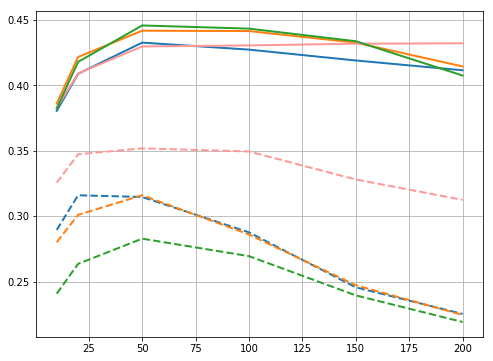

In [32]:
data_pca       = results_PCA['top10_presence']
data           = results['top10_presence']

color_sequence = ['#1f77b4', '#ff7f0e', '#ff9896', '#2ca02c']

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for sim, color in zip(similarity_measures, color_sequence):
    plt.plot(k_grid, data_pca.loc[results_PCA['similarity_measure'] == sim], color, linewidth = 2)
    plt.plot(k_grid, data.loc[results['similarity_measure'] == sim], color, linewidth = 2, 
             linestyle = "--")
plt.grid()


# Add title and legend
fig.savefig('plots/k_tuning_top10.pdf')

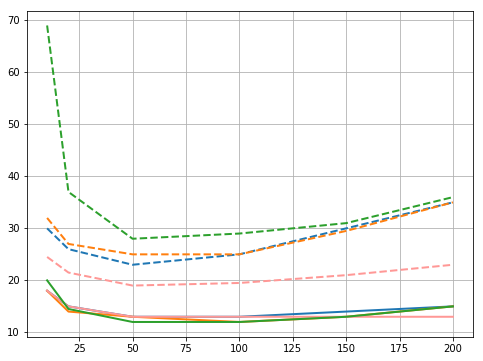

In [33]:
data_pca       = results_PCA['median_rank']
data           = results['median_rank']

color_sequence = ['#1f77b4', '#ff7f0e', '#ff9896', '#2ca02c']

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for sim, color in zip(similarity_measures, color_sequence):
    plt.plot(k_grid, data_pca.loc[results_PCA['similarity_measure'] == sim], color, linewidth = 2)
    plt.plot(k_grid, data.loc[results['similarity_measure'] == sim], color, linewidth = 2, 
             linestyle = "--")
plt.grid()

# Add title and legend
fig.savefig('plots/k_tuning_median.pdf')

After applying PCA, the results improve considerably and become less senstive to the similarity measure

## Run all similarity metrics with best k and PCA (100)